In [38]:
# The assignment is structured in a way that its modular so thats its easier to debug whats wrong

import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
from scipy.signal import butter, filtfilt, iirnotch
from scipy.linalg import eigh
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, classification_report,
                             confusion_matrix)
import pickle
import json
import time
import warnings
warnings.filterwarnings('ignore')

In [39]:
# SECTION 1: DATA LOADING AND BASIC SETUP

CHAR_MATRIX = np.array([
    ['A', 'B', 'C', 'D', 'E', 'F'],
    ['G', 'H', 'I', 'J', 'K', 'L'],
    ['M', 'N', 'O', 'P', 'Q', 'R'],
    ['S', 'T', 'U', 'V', 'W', 'X'],
    ['Y', 'Z', '1', '2', '3', '4'],
    ['5', '6', '7', '8', '9', '_']
])

def load_data(file_path):
    data = sio.loadmat(file_path)
    dataset = {
        "signal": data["Signal"],
        "flashing": data["Flashing"],
        "stimulus_code": data["StimulusCode"]
    }

    if "StimulusType" in data:
        dataset["stimulus_type"] = data["StimulusType"]

    if "TargetChar" in data:
        dataset["target_char"] = data["TargetChar"]

    return dataset


def get_char_from_codes(row_code, col_code):
    row_index = row_code - 1
    col_index = col_code - 1
    return CHAR_MATRIX[row_index, col_index]



In [40]:
# SECTION 2: EEG SIGNAL ACQUISITION & PREPROCESSING

def bandpass_filter(signal, lowcut=0.1, highcut=20, fs=240, order=5):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist

    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, signal, axis=-2)


def notch_filter(signal, freq=50, fs=240, Q=30):
    b, a = iirnotch(freq / (0.5 * fs), Q)
    return filtfilt(b, a, signal, axis=-2)



def baseline_correction(epoch, baseline_samples=50):
    baseline = np.mean(epoch[:baseline_samples, :], axis=0)
    return epoch - baseline


def downsample_signal(signal, original_fs=240, target_fs=60):
    factor = original_fs // target_fs
    return signal[:, ::factor, :]


def artifact_rejection(signal, threshold=100):
    max_amp = np.max(np.abs(signal), axis=(1, 2))
    return signal[max_amp < threshold]


def preprocess_pipeline(data, apply_bandpass=True, apply_notch=True,
                       apply_downsample=True, fs=240):
    signal = data["signal"]

    if apply_bandpass:
        signal = bandpass_filter(signal, fs=fs)

    if apply_notch:
        signal = notch_filter(signal, fs=fs)

    if apply_downsample:
        signal = downsample_signal(signal, original_fs=fs, target_fs=60)

    data["signal"] = signal
    return data


def extract_epochs(data, epoch_length_ms=800, fs=60):
    signal = data["signal"]
    flashing = data["flashing"]
    stimulus_code = data["stimulus_code"]
    stimulus_type = data.get("stimulus_type", None)

    epoch_samples = int(epoch_length_ms * fs / 1000)

    epochs = []
    labels = []
    codes_list = []
    char_idx_list = []

    n_trials = signal.shape[0]

    for trial in range(n_trials):
        flash_onsets = np.where(np.diff(flashing[trial]) == 1)[0] + 1

        for onset in flash_onsets:
            if onset + epoch_samples <= signal.shape[1]:
                epoch = signal[trial, onset:onset + epoch_samples, :]
                epoch = baseline_correction(epoch)

                epochs.append(epoch)
                codes_list.append(stimulus_code[trial, onset])

                if stimulus_type is not None:
                    labels.append(stimulus_type[trial, onset])

                char_idx_list.append(trial)

    epochs = np.array(epochs)
    labels = np.array(labels) if stimulus_type is not None else None


    return {
        'epochs': epochs,
        'labels': labels,
        'codes': np.array(codes_list),
        'char_indices': np.array(char_idx_list)
    }

def plot_erp_responses(epoch_data, channel_idx=31, fs=60):
    epochs = epoch_data["epochs"]
    labels = epoch_data["labels"]

    target_epochs = epochs[labels == 1][:, :, channel_idx]
    nontarget_epochs = epochs[labels == 0][:, :, channel_idx]

    time = np.arange(epochs.shape[1]) / fs * 1000

    target_mean = np.mean(target_epochs, axis=0)
    nontarget_mean = np.mean(nontarget_epochs, axis=0)

    target_se = np.std(target_epochs, axis=0) / np.sqrt(len(target_epochs))
    nontarget_se = np.std(nontarget_epochs, axis=0) / np.sqrt(len(nontarget_epochs))

    plt.figure(figsize=(10, 5))
    plt.plot(time, target_mean, label="Target", color="red")
    plt.plot(time, nontarget_mean, label="Non-Target", color="blue")

    plt.fill_between(time, target_mean - target_se, target_mean + target_se,
                     color="red", alpha=0.3)
    plt.fill_between(time, nontarget_mean - nontarget_se,
                     nontarget_mean + nontarget_se, color="blue", alpha=0.3)

    plt.axvspan(250, 450, color='gray', alpha=0.2)

    plt.xlabel("Time (ms)")
    plt.ylabel("Amplitude (µV)")
    plt.title("ERP at Cz (Channel 31)")
    plt.legend()
    plt.grid(True)
    plt.show()

    p300_idx = (time >= 250) & (time <= 450)
    diff = np.mean(target_mean[p300_idx]) - np.mean(nontarget_mean[p300_idx])
    print(f"P300 amplitude difference: {diff:.2f} µV")




In [41]:
# SECTION 3: FEATURE ENGINEERING & BASELINE CLASSIFIERS

def extract_time_domain_features(epochs):
    n_epochs, n_samples, n_channels = epochs.shape
    return epochs.reshape(n_epochs, n_samples * n_channels)

def extract_pca_features(epochs, n_components=20):
    X = extract_time_domain_features(epochs)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X_scaled)

    return X_pca, scaler, pca


def extract_csp_features(epochs, labels, n_components=6):
    target_epochs = epochs[labels == 1]
    non_target_epochs = epochs[labels == 0]
    print(f"  Target epochs for CSP: {len(target_epochs)}")
    print(f"  Non-target epochs for CSP: {len(non_target_epochs)}")

    # Compute covariance matrices
    def compute_cov(data):
        covs = []
        for ep in data:
            ep = ep.T
            cov = np.cov(ep)
            cov /= np.trace(cov)
            covs.append(cov)
        return np.mean(covs, axis=0)

    cov_target = compute_cov(target_epochs)
    cov_nontarget = compute_cov(non_target_epochs)

    eigvals, eigvecs = eigh(cov_target, cov_target + cov_nontarget)

    idx = np.argsort(eigvals)[::-1]
    eigvecs = eigvecs[:, idx]

    W = np.hstack([
        eigvecs[:, :n_components // 2],
        eigvecs[:, -n_components // 2:]
    ])

    features = []
    for epoch in epochs:
        Z = np.dot(W.T, epoch.T)
        var = np.var(Z, axis=1)
        features.append(np.log(var / np.sum(var)))

    return np.array(features), W


def extract_features(epoch_data, method='pca', n_components=20):
    epochs = epoch_data["epochs"]
    labels = epoch_data["labels"]

    if method == 'time_domain':
        return extract_time_domain_features(epochs)

    elif method == 'pca':
        X, scaler, pca = extract_pca_features(epochs, n_components)
        return X, scaler, pca

    elif method == 'csp':
        X, W = extract_csp_features(epochs, labels, n_components)
        return X, W

    else:
        raise ValueError("Unknown feature extraction method")


def train_lda_classifier(X_train, y_train):
    lda = LinearDiscriminantAnalysis(priors=[0.5, 0.5])
    lda.fit(X_train, y_train)
    return lda


def train_logistic_regression(X_train, y_train):
    model = LogisticRegression(class_weight='balanced', max_iter=1000)
    model.fit(X_train, y_train)
    return model


def evaluate_classifier(model, X_test, y_test, model_name="Model"):
    y_pred = model.predict(X_test)

    print(f"\n===== {model_name} Evaluation =====")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("F1 Score:", f1_score(y_test, y_pred))
    print("Precision:", precision_score(y_test, y_pred))
    print("Recall:", recall_score(y_test, y_pred))

    print("\nConfusion Matrix:")
    print(confusion_matrix(y_test, y_pred))

    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))


class CSPTransformer:
    def __init__(self, W):
        self.W = W

    def transform(self, epochs):
        features = []
        for epoch in epochs:
            Z = np.dot(self.W.T, epoch.T)
            var = np.var(Z, axis=1)
            features.append(np.log(var / np.sum(var)))
        return np.array(features)


In [42]:
# SECTION 4: CLASSICAL MACHINE LEARNING MODELS

def train_svm_classifier(X_train, y_train, kernel='rbf', C=1.0):
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)

    model = SVC(kernel=kernel, C=C, class_weight='balanced')
    model.fit(X_train_scaled, y_train)

    return model, scaler

def train_random_forest(X_train, y_train, n_estimators=100):
    print(f"\n  Training Random Forest (n_estimators={n_estimators})...")
    model = RandomForestClassifier(
        n_estimators=n_estimators,
        class_weight='balanced',
        random_state=42
    )
    model.fit(X_train, y_train)
    return model


def train_gradient_boosting(X_train, y_train, n_estimators=100):
    print(f"\n  Training Gradient Boosting (n_estimators={n_estimators})...")

    class_counts = np.bincount(y_train.astype(int))
    class_weights = {
        0: 1.0 / class_counts[0],
        1: 1.0 / class_counts[1]
    }
    sample_weights = np.array([class_weights[y] for y in y_train])

    model = GradientBoostingClassifier(n_estimators=n_estimators)
    model.fit(X_train, y_train, sample_weight=sample_weights)

    return model



def compare_all_classical_models(X_train, y_train, X_test, y_test):
    results = []

    class_counts = np.bincount(y_train.astype(int))
    class_weights = {
        0: 1.0 / class_counts[0],
        1: 1.0 / class_counts[1]
    }
    sample_weights = np.array([class_weights[y] for y in y_train])

    svm_model, svm_scaler = train_svm_classifier(X_train, y_train)

    models = {
    "LDA": train_lda_classifier(X_train, y_train),
    "Logistic Regression": train_logistic_regression(X_train, y_train),
    "SVM": svm_model,
    "Random Forest": train_random_forest(X_train, y_train),
    "Gradient Boosting": train_gradient_boosting(X_train, y_train)
    }


    for name, model in models.items():
        print(f"\nEvaluating {name}...")
        if name == "SVM":
            X_test_scaled = svm_scaler.transform(X_test)
            y_pred = model.predict(X_test_scaled)
        else:
            y_pred = model.predict(X_test)

        acc = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        prec = precision_score(y_test, y_pred)
        rec = recall_score(y_test, y_pred)

        results.append({
            "Model": name,
            "Accuracy": acc,
            "F1": f1,
            "Precision": prec,
            "Recall": rec
        })

    print("\n===== Model Comparison === Development Mode Activated!!!")
    for r in results:
        print(
            f"{r['Model']:20s} | "
            f"Acc: {r['Accuracy']:.3f} | "
            f"F1: {r['F1']:.3f} | "
            f"Prec: {r['Precision']:.3f} | "
            f"Recall: {r['Recall']:.3f}"
        )

    return results,models


def save_model(model, filepath):
    with open(filepath, 'wb') as f:
        pickle.dump(model, f)
    print(f"\n  Model saved to: {filepath}")

def load_model(filepath):
    with open(filepath, 'rb') as f:
        model = pickle.load(f)
    print(f"\n  Model loaded from: {filepath}")
    return model

In [43]:
# STEP 1: LOAD DATA

print("\n" + "="*70)
print("STEP 1: LOADING DATA")
print("="*70)

from google.colab import drive

drive.mount('/content/drive')
DATA_PATH = '/content/drive/MyDrive/EEG dataset/'

train_data_A = load_data(DATA_PATH + 'Subject_A_Train.mat')
test_data_A = load_data(DATA_PATH + 'Subject_A_Test.mat')
train_data_B = load_data(DATA_PATH + 'Subject_B_Train.mat')
test_data_B = load_data(DATA_PATH + 'Subject_B_Test.mat')



STEP 1: LOADING DATA
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [44]:
# STEP 2: PREPROCESSING

print("\n" + "="*70)
print("STEP 2: PREPROCESSING")
print("="*70)

print("\n--- Subject A ---")
train_proc_A = preprocess_pipeline(train_data_A)
test_proc_A = preprocess_pipeline(test_data_A)

print("\n--- Subject B ---")
train_proc_B = preprocess_pipeline(train_data_B)
test_proc_B = preprocess_pipeline(test_data_B)



STEP 2: PREPROCESSING

--- Subject A ---

--- Subject B ---


In [45]:
# STEP 3: EPOCH EXTRACTION

print("\n" + "="*70)
print("STEP 3: EPOCH EXTRACTION")
print("="*70)

print("\n--- Subject A ---")
train_epochs_A = extract_epochs(train_proc_A)
test_epochs_A = extract_epochs(test_proc_A)

print("\n--- Subject B ---")
train_epochs_B = extract_epochs(train_proc_B)
test_epochs_B = extract_epochs(test_proc_B)


STEP 3: EPOCH EXTRACTION

--- Subject A ---

--- Subject B ---



STEP 4: VISUALIZING ERP RESPONSES

--- Subject A ---


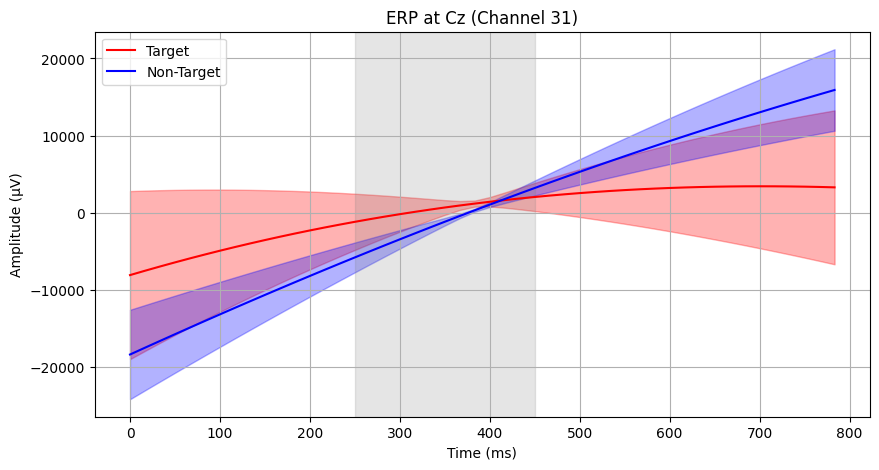

P300 amplitude difference: 1800.21 µV


In [46]:
# STEP 4: VISUALIZE ERP

print("\n" + "="*70)
print("STEP 4: VISUALIZING ERP RESPONSES")
print("="*70)

print("\n--- Subject A ---")
plot_erp_responses(train_epochs_A, channel_idx=31)

In [47]:
# STEP 5: FEATURE EXTRACTION

print("\n" + "="*70)
print("STEP 5: FEATURE EXTRACTION")
print("="*70)

print("\n--- Subject A: Feature Comparison ---")

X_pca20_A, scaler20_A, pca20_A = extract_pca_features(
    train_epochs_A['epochs'], n_components=20
)

X_pca50_A, scaler50_A, pca50_A = extract_pca_features(
    train_epochs_A['epochs'], n_components=50
)

X_csp_A, W_csp_A = extract_csp_features(
    train_epochs_A['epochs'],
    train_epochs_A['labels'],
    n_components=6
)

X_time_A = train_epochs_A['epochs'].reshape(
    train_epochs_A['epochs'].shape[0], -1
)

y_A = train_epochs_A['labels']


X_tr, X_te, y_tr, y_te = train_test_split(
    X_pca20_A, y_A, test_size=0.2, stratify=y_A, random_state=42
)
lda = train_lda_classifier(X_tr, y_tr)
y_pred = lda.predict(X_te)
acc_pca20 = accuracy_score(y_te, y_pred)
f1_pca20 = f1_score(y_te, y_pred)

X_tr, X_te, y_tr, y_te = train_test_split(
    X_pca50_A, y_A, test_size=0.2, stratify=y_A, random_state=42
)
lda = train_lda_classifier(X_tr, y_tr)
y_pred = lda.predict(X_te)
acc_pca50 = accuracy_score(y_te, y_pred)
f1_pca50 = f1_score(y_te, y_pred)

X_tr, X_te, y_tr, y_te = train_test_split(
    X_csp_A, y_A, test_size=0.2, stratify=y_A, random_state=42
)
lda = train_lda_classifier(X_tr, y_tr)
y_pred = lda.predict(X_te)
acc_csp = accuracy_score(y_te, y_pred)
f1_csp = f1_score(y_te, y_pred)

X_tr, X_te, y_tr, y_te = train_test_split(
    X_time_A, y_A, test_size=0.2, stratify=y_A, random_state=42
)
lda = train_lda_classifier(X_tr, y_tr)
y_pred = lda.predict(X_te)
acc_time = accuracy_score(y_te, y_pred)
f1_time = f1_score(y_te, y_pred)

print("\n" + "="*70)
print("FEATURE COMPARISON (Balanced Classifiers)")
print("="*70)
print(f"PCA (20 comp):      Accuracy={acc_pca20:.4f}, F1={f1_pca20:.4f}")
print(f"PCA (50 comp):      Accuracy={acc_pca50:.4f}, F1={f1_pca50:.4f}")
print(f"CSP (6 comp):       Accuracy={acc_csp:.4f}, F1={f1_csp:.4f}")
print(f"Time-Domain (3072): Accuracy={acc_time:.4f}, F1={f1_time:.4f}")

scores = {
    'pca20': f1_pca20,
    'pca50': f1_pca50,
    'csp': f1_csp,
    'time': f1_time
}

feature_method_A = max(scores, key=scores.get)
print(f"\nBest feature method (Subject A): {feature_method_A.upper()}")

if feature_method_A == 'time':
    X_train_full_A = X_time_A
    feature_obj_A = None
    n_components_A = None
elif feature_method_A == 'pca20':
    X_train_full_A = X_pca20_A
    feature_obj_A = pca20_A
    n_components_A = 20
    feature_method_A = 'pca'
elif feature_method_A == 'pca50':
    X_train_full_A = X_pca50_A
    feature_obj_A = pca50_A
    n_components_A = 50
    feature_method_A = 'pca'
else:
    X_train_full_A = X_csp_A
    feature_obj_A = CSPTransformer(W_csp_A)
    n_components_A = 6
    feature_method_A = 'csp'

X_train_A, X_val_A, y_train_A, y_val_A = train_test_split(
    X_train_full_A,
    train_epochs_A['labels'],
    test_size=0.2,
    random_state=42,
    stratify=train_epochs_A['labels']
)
print(f"\nSubject A splits: Training={len(X_train_A)}, Validation={len(X_val_A)}")

if feature_method_A == 'time':
    X_test_A = test_epochs_A['epochs'].reshape(len(test_epochs_A['epochs']), -1)
elif feature_method_A == 'pca':
    X_test_A = feature_obj_A.transform(
        test_epochs_A['epochs'].reshape(test_epochs_A['epochs'].shape[0], -1)
    )
else:
    X_test_A = feature_obj_A.transform(test_epochs_A['epochs'])

print(f"Test features: {X_test_A.shape}")

print("\n--- Subject B: Feature Extraction ---")
print(f"\nUsing {feature_method_A.upper()} (same as Subject A)...")

if feature_method_A == 'time':
    X_train_full_B = train_epochs_B['epochs'].reshape(len(train_epochs_B['epochs']), -1)
    X_test_B = test_epochs_B['epochs'].reshape(len(test_epochs_B['epochs']), -1)
elif feature_method_A == 'pca':
    X_train_full_B, pca_B = extract_features(
        train_epochs_B, method='pca', n_components=n_components_A
    )
    X_test_B = pca_B.transform(
        test_epochs_B['epochs'].reshape(test_epochs_B['epochs'].shape[0], -1)
    )
else:
    X_train_full_B, csp_B = extract_features(
        train_epochs_B, method='csp', n_components=6
    )
    X_test_B = CSPTransformer(csp_B).transform(test_epochs_B['epochs'])

X_train_B, X_val_B, y_train_B, y_val_B = train_test_split(
    X_train_full_B,
    train_epochs_B['labels'],
    test_size=0.2,
    random_state=42,
    stratify=train_epochs_B['labels']
)
print(f"Subject B splits: Training={len(X_train_B)}, Validation={len(X_val_B)}, Test features: {X_test_B.shape}")


feature_config = {
    "method": feature_method_A,
    "n_components": n_components_A
}

if feature_method_A in ['pca', 'csp']:
    feature_config["transformer"] = feature_obj_A
else:
    feature_config["transformer"] = None

print("\nStored feature configuration:")
print(feature_config)


scaler_A = None
scaler_B = None

pca_A = None
pca_B = None

if feature_method_A == 'pca':
    pca_A = feature_obj_A
    pca_B = feature_obj_A



STEP 5: FEATURE EXTRACTION

--- Subject A: Feature Comparison ---
  Target epochs for CSP: 637
  Non-target epochs for CSP: 3188

FEATURE COMPARISON (Balanced Classifiers)
PCA (20 comp):      Accuracy=0.7176, F1=0.2117
PCA (50 comp):      Accuracy=0.7072, F1=0.1318
CSP (6 comp):       Accuracy=0.5830, F1=0.3198
Time-Domain (3072): Accuracy=0.6209, F1=0.2204

Best feature method (Subject A): CSP

Subject A splits: Training=3060, Validation=765
Test features: (4500, 6)

--- Subject B: Feature Extraction ---

Using CSP (same as Subject A)...
  Target epochs for CSP: 646
  Non-target epochs for CSP: 3179
Subject B splits: Training=3060, Validation=765, Test features: (4500, 6)

Stored feature configuration:
{'method': 'csp', 'n_components': 6, 'transformer': <__main__.CSPTransformer object at 0x7fadae9ef560>}


In [48]:
# STEP 6: BASELINE CLASSIFIERS

print("\n" + "="*70)
print("STEP 6: BASELINE CLASSIFIERS (Subject A)")
print("="*70)

lda_A = train_lda_classifier(X_train_A, y_train_A)
acc_lda = evaluate_classifier(lda_A, X_val_A, y_val_A, "LDA")

lr_A = train_logistic_regression(X_train_A, y_train_A)
acc_lr = evaluate_classifier(lr_A, X_val_A, y_val_A, "Logistic Regression")



STEP 6: BASELINE CLASSIFIERS (Subject A)

===== LDA Evaluation =====
Accuracy: 0.5830065359477125
F1 Score: 0.31982942430703626
Precision: 0.21929824561403508
Recall: 0.5905511811023622

Confusion Matrix:
[[371 267]
 [ 52  75]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.88      0.58      0.70       638
         1.0       0.22      0.59      0.32       127

    accuracy                           0.58       765
   macro avg       0.55      0.59      0.51       765
weighted avg       0.77      0.58      0.64       765


===== Logistic Regression Evaluation =====
Accuracy: 0.5673202614379085
F1 Score: 0.3231083844580777
Precision: 0.21823204419889503
Recall: 0.6220472440944882

Confusion Matrix:
[[355 283]
 [ 48  79]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.88      0.56      0.68       638
         1.0       0.22      0.62      0.32       127

    accuracy                  

In [49]:
# STEP 7: CLASSICAL ML MODELS

print("\n" + "="*70)
print("STEP 7: CLASSICAL MACHINE LEARNING (Subject A)")
print("="*70)

results_classical_A, models_A = compare_all_classical_models(
    X_train_A, y_train_A, X_val_A, y_val_A
)
svm_A, scaler_A = train_svm_classifier(X_train_A, y_train_A)
svm_B, scaler_B = train_svm_classifier(X_train_B, y_train_B)


STEP 7: CLASSICAL MACHINE LEARNING (Subject A)

  Training Random Forest (n_estimators=100)...

  Training Gradient Boosting (n_estimators=100)...

Evaluating LDA...

Evaluating Logistic Regression...

Evaluating SVM...

Evaluating Random Forest...

Evaluating Gradient Boosting...

===== Model Comparison === Development Mode Activated!!!
LDA                  | Acc: 0.583 | F1: 0.320 | Prec: 0.219 | Recall: 0.591
Logistic Regression  | Acc: 0.567 | F1: 0.323 | Prec: 0.218 | Recall: 0.622
SVM                  | Acc: 0.519 | F1: 0.267 | Prec: 0.179 | Recall: 0.528
Random Forest        | Acc: 0.830 | F1: 0.000 | Prec: 0.000 | Recall: 0.000
Gradient Boosting    | Acc: 0.593 | F1: 0.254 | Prec: 0.183 | Recall: 0.417


In [50]:
# STEP 8: EXPORT MODELS

print("\n" + "="*70)
print("STEP 8: EXPORTING MODELS")
print("="*70)

import os
os.makedirs('models', exist_ok=True)

save_model({
    'model': svm_A,
    'scaler': scaler_A,
    'pca': pca_A
}, 'models/subject_A_svm.pkl')

save_model({
    'model': svm_B,
    'scaler': scaler_B,
    'pca': pca_B
}, 'models/subject_B_svm.pkl')




STEP 8: EXPORTING MODELS

  Model saved to: models/subject_A_svm.pkl

  Model saved to: models/subject_B_svm.pkl
